<a href="https://colab.research.google.com/github/123prashanth123/Fault-Detection-System/blob/main/Siamese%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

In [ ]:
from IPython.display import clear_output
from google.colab import drive
drive.mount("/content/gdrive")

!pip install -q --upgrade imgaug
!pip install -q imagecorruptions

clear_output()

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import models, transforms, ops
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset

import imgaug
from imgaug import augmenters
from sklearn.model_selection import KFold

import os
import re
import cv2
import random as r
from time import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
FEA_TRANSFORM = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ])
ROI_TRANSFORM = transforms.Compose([transforms.ToTensor(), ])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIZE = 224
SEED = 0
EMBED = 2048
FEATURE_VECTOR_LENGTH = 2048 
DATASET_PATH = "/content/gdrive/My Drive/Datasets/FDS"

In [ ]:
def breaker(num=50, char="*"):
    print("\n" + num*char + "\n")

def preprocess(image):
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    image = cv2.resize(src=image, dsize=(256, 256), interpolation=cv2.INTER_AREA)
    h, w, _ = image.shape
    relief = SIZE // 2
    cx, cy = w // 2, h // 2
    return image[cy - relief:cy + relief, cx - relief:cx + relief, :]

def normalize(x):
    for i in range(x.shape[0]):
        x[i] = (x[i] - torch.min(x[i])) / (torch.max(x[i]) - torch.min(x[i]))
    return x

# Build Pretrained Models

In [ ]:
class RoIExtractor(nn.Module):
    def __init__(self):
        super(RoIExtractor, self).__init__()
        self.model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True)
    
    def forward(self, x):
        return self.model(x)


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.model = models.vgg16_bn(pretrained=True, progress=True)
        self.model = nn.Sequential(*[*self.model.children()][:-2])
        self.model.add_module("Adaptive Average Pool", nn.AdaptiveAvgPool2d(output_size=(2, 2)))
        self.model.add_module("Flatten", nn.Flatten())
    
    def forward(self, x):
        return self.model(x)


roi_extractor = RoIExtractor().to(DEVICE)
roi_extractor.eval()
fea_extractor = FeatureExtractor().to(DEVICE)
fea_extractor.eval()
clear_output()

# Build Loaders

In [ ]:
def build_dataloaders(part_name: str, num_samples: int, batch_size: int):
    class FEDS(Dataset):
        def __init__(self, X=None, transform=None):
            self.transform = transform
            self.X = X

        def __len__(self):
            return self.X.shape[0]

        def __getitem__(self, idx):
            return self.transform(self.X[idx])
    

    class SiameseDS(Dataset):
        def __init__(self, anchor=None, p_vector=None, n_vector=None):
            self.anchor = anchor
            self.p_vector = p_vector
            self.n_vector = n_vector

            if self.p_vector.shape[0] != self.n_vector.shape[0]:
                min_val = min(self.p_vector.shape[0], self.n_vector.shape[0])
                self.anchor = np.array([anchor for _ in range(min_val)])

                self.pX = np.concatenate((self.anchor, np.expand_dims(self.p_vector[:min_val], axis=1)), axis=1)
                self.nX = np.concatenate((self.anchor, np.expand_dims(self.n_vector[:min_val], axis=1)), axis=1)
                self.py = np.ones((self.pX.shape[0], 1))
                self.ny = np.zeros((self.nX.shape[0], 1))

                self.X = np.concatenate((self.pX, self.nX), axis=0)
                self.y = np.concatenate((self.py, self.ny), axis=0)

            else:
                self.anchor = np.array([anchor for _ in range(self.p_vector.shape[0])])

                self.pX = np.concatenate((self.anchor, np.expand_dims(self.p_vector, axis=1)), axis=1)
                self.nX = np.concatenate((self.anchor, np.expand_dims(self.n_vector, axis=1)), axis=1)
                self.py = np.ones((self.pX.shape[0], 1))
                self.ny = np.zeros((self.nX.shape[0], 1))

                self.X = np.concatenate((self.pX, self.nX), axis=0)
                self.y = np.concatenate((self.py, self.ny), axis=0)

        def __len__(self):
            return self.X.shape[0]

        def __getitem__(self, idx):
            return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])
    

    def get_augments(augment_seed=None): 
        imgaug.seed(entropy=augment_seed)
        dataset_augment = augmenters.Sequential([
            augmenters.HorizontalFlip(p=0.25),
            augmenters.VerticalFlip(p=0.25),
            augmenters.SomeOf(5, [
                augmenters.blur.GaussianBlur(sigma=(0, 5), seed=augment_seed),
                augmenters.blur.MedianBlur(k=(1, 7), seed=augment_seed),
                augmenters.size.Crop(percent=(0, 0.15), seed=augment_seed),
                augmenters.geometric.Affine(rotate=(-45, 45), scale=(0.75, 1.25), translate_percent=(-0.15, 0.15), seed=augment_seed, cval=(0, 255), mode="symmetric"),
                augmenters.geometric.Rot90(k=(1, 3), seed=augment_seed),
                augmenters.arithmetic.Dropout(p=(0, 0.075), seed=augment_seed),
                augmenters.arithmetic.SaltAndPepper(p=(0, 0.075), seed=augment_seed),
                augmenters.color.MultiplyBrightness(mul=(0.5, 1.5)),
                augmenters.color.MultiplySaturation(mul=(0, 5), seed=augment_seed),
                augmenters.iaa_convolutional.Sharpen(alpha=(0.75, 1), lightness=(0.75, 1.25), seed=augment_seed),
                augmenters.iaa_convolutional.Emboss(alpha=(0.75, 1), strength=(0.75, 1.25), seed=augment_seed),
                augmenters.contrast.CLAHE(seed=augment_seed),
                augmenters.contrast.GammaContrast(gamma=(0.2, 5), seed=augment_seed),
            ])
        ])
                                                 
        imgaug.seed(entropy=augment_seed)
        roi_augment = augmenters.Sequential([augmenters.imgcorruptlike.GlassBlur(severity=5, seed=augment_seed),
                                             augmenters.imgcorruptlike.Pixelate(severity=5, seed=augment_seed)])

        return dataset_augment, roi_augment
    

    def make_data(part_name=None, cls="Positive", num_samples=None, batch_size=64, fea_extractor=None):
        path = os.path.join(os.path.join(DATASET_PATH, part_name), "Positive")
        image = preprocess(cv2.imread(os.path.join(path, "Snapshot_1.png"), cv2.IMREAD_COLOR))
        anchor = image.copy()

        r.seed(SEED)
        np.random.seed(SEED)
        dataset_augment, roi_augment = get_augments(SEED)

        if re.match(r"Negative", cls, re.IGNORECASE):
            with torch.no_grad():
                output = roi_extractor(ROI_TRANSFORM(image).to(DEVICE).unsqueeze(dim=0))
            cnts, scrs = output[0]["boxes"], output[0]["scores"]
            if len(cnts) != 0:
                cnts = ops.clip_boxes_to_image(cnts, (SIZE, SIZE))
                best_box = ops.nms(cnts, scrs, 0.3)[0]

                x1, y1, x2, y2 = int(cnts[best_box][0]), int(cnts[best_box][1]), int(cnts[best_box][2]), int(cnts[best_box][3])
                roi_img = image[y1:y2, x1:x2]
                roi_img = roi_augment(images=np.expand_dims(roi_img, axis=0))
                image[y1:y2, x1:x2] = roi_img.squeeze()

        # if not re.match(r"Negative", cls, re.IGNORECASE):
        #     images = np.array(dataset_augment(images=[image for _ in range(num_samples)]))
        # else:
        #     image = image / 255.0
        #     images = np.array(dataset_augment(images=[np.clip((image + (FACTOR * np.random.normal(size=image.shape))) * 255, 0, 255).astype("uint8") for _ in range(num_samples)]))
        
        images = np.array(dataset_augment(images=[image for _ in range(num_samples)]))

        feature_data_setup = FEDS(X=images, transform=FEA_TRANSFORM)
        feature_data = DL(feature_data_setup, batch_size=batch_size, shuffle=False)
        features = torch.zeros(1, FEATURE_VECTOR_LENGTH).to(DEVICE)

        for X in feature_data:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = fea_extractor(X)
            features = torch.cat((features, output), dim=0)
        
        del output, fea_extractor
        torch.cuda.empty_cache()
        return anchor, normalize(features[1:]).detach().cpu().numpy()
    

    def get_single_image_features(image=None):
        with torch.no_grad():
            features = fea_extractor(FEA_TRANSFORM(image).to(DEVICE).unsqueeze(dim=0))
        return normalize(features).detach().cpu().numpy()

       
    anchor, p_features = make_data(part_name=part_name, cls="Positive", num_samples=num_samples, batch_size=64, fea_extractor=fea_extractor)
    _, n_features      = make_data(part_name=part_name, cls="Negative", num_samples=num_samples, batch_size=64, fea_extractor=fea_extractor)

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED).split(n_features)
    for tr_idx, va_idx in kf:
        train_indices, valid_indices = tr_idx, va_idx
        break
    
    anchor = get_single_image_features(image=anchor)
    p_train, p_valid = p_features[train_indices], p_features[valid_indices]
    n_train, n_valid = n_features[train_indices], n_features[valid_indices]

    breaker()
    print("Building Dataloaders ....")
    tr_data_setup = SiameseDS(anchor=anchor, p_vector=p_train, n_vector=n_train)
    va_data_setup = SiameseDS(anchor=anchor, p_vector=p_valid, n_vector=n_valid)

    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, pin_memory=True, generator=torch.manual_seed(SEED), ), 
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False, pin_memory=True)
    }

    return dataloaders

# Build Model

In [ ]:
def build_siamese_model():
    class SiameseNetwork(nn.Module):
        def __init__(self, IL=FEATURE_VECTOR_LENGTH, embed=EMBED):
            super(SiameseNetwork, self).__init__()

            self.embedder = nn.Sequential()

            self.embedder.add_module("BN", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            self.embedder.add_module("FC", nn.Linear(in_features=IL, out_features=embed))
            self.embedder.add_module("AN", nn.ReLU())

            self.classifier = nn.Sequential()
            self.classifier.add_module("BN", nn.BatchNorm1d(num_features=embed, eps=1e-5))
            self.classifier.add_module("FC", nn.Linear(in_features=embed, out_features=1))
        
        def getOptimizer(self, A_S=True, lr=1e-3, wd=0):
            if A_S:
                return optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
            else:
                return optim.SGD(self.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

        def forward(self, x1, x2=None):
            if x2 is not None:
                x1 = self.embedder(x1)
                x2 = self.embedder(x2)
                x = torch.abs(x1 - x2)
                x = self.classifier(x)
            else:
                x = self.classifier(self.embedder(x1))
            
            return x
        
    torch.manual_seed(SEED)
    model = SiameseNetwork()
    return model

# Helper

In [ ]:
def train(part_name, model, tr_data, va_data, epochs, lr, wd, es):
    def fit_(model=None, optimizer=None, scheduler=None, epochs=None, early_stopping_patience=None,
             trainloader=None, validloader=None, criterion=None, device=None, path=None, verbose=False):

        def getAccuracy(y_pred=None, y_true=None):
            y_pred, y_true = torch.sigmoid(y_pred).detach(), y_true.detach()

            y_pred[y_pred > 0.5] = 1
            y_pred[y_pred <= 0.5] = 0

            return torch.count_nonzero(y_pred == y_true).item() / len(y_true)
    
        breaker()
        print("Training ...")
        breaker()

        model.to(device)

        DLS = {"train": trainloader, "valid": validloader}
        bestLoss = {"train": np.inf, "valid": np.inf}
        bestAccs = {"train": 0.0, "valid": 0.0}

        Losses = []
        Accuracies = []

        start_time = time()
        for e in range(epochs):
            e_st = time()

            epochLoss = {"train": 0.0, "valid": 0.0}
            epochAccs = {"train": 0.0, "valid": 0.0}

            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()

                lossPerPass = []
                accsPerPass = []

                for X, y in DLS[phase]:
                    X = X.to(device)
                    if y.dtype == torch.int64:
                        y = y.to(device).view(-1)
                    else:
                        y = y.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(X[:, 0, :], X[:, 1, :])
                        loss = criterion(output, y)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass.append(loss.item())
                    accsPerPass.append(getAccuracy(output, y))
                epochLoss[phase] = np.mean(np.array(lossPerPass))
                epochAccs[phase] = np.mean(np.array(accsPerPass))
            Losses.append(epochLoss)
            Accuracies.append(epochAccs)

            if early_stopping_patience:
                if epochLoss["valid"] < bestLoss["valid"]:
                    bestLoss = epochLoss
                    BLE = e + 1
                    torch.save({"model_state_dict": model.state_dict(),
                                "optim_state_dict": optimizer.state_dict()},
                            os.path.join(path, "State.pt"))
                    early_stopping_step = 0
                else:
                    early_stopping_step += 1
                    if early_stopping_step > early_stopping_patience:
                        print("\nEarly Stopping at Epoch {}".format(e + 1))
                        break
            
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                            os.path.join(path, "State.pt"))

            if epochAccs["valid"] > bestAccs["valid"]:
                bestAccs = epochAccs
                BAE = e + 1

            if verbose:
                print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Train Accs : {:.5f} | \
Valid Accs : {:.5f} | Time: {:.2f} seconds".format(e + 1,
                                                   epochLoss["train"], epochLoss["valid"],
                                                   epochAccs["train"], epochAccs["valid"],
                                                  time() - e_st))

            if scheduler:
                scheduler.step(epochLoss["valid"])

        breaker()
        print("-----> Best Validation Loss at Epoch {}".format(BLE))
        breaker()
        print("-----> Best Validation Accs at Epoch {}".format(BAE))
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time() - start_time) / 60))
        breaker()
        print("Training Complete")

        return Losses, Accuracies, BLE, BAE
    
    optimizer = model.getOptimizer(lr=lr, wd=wd)
    checkpoint_path = os.path.join("/content", part_name)
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    L, A, BLE, BAE = fit_(model=model, optimizer=optimizer, epochs=epochs, early_stopping_patience=es,
                          trainloader=tr_data, validloader=va_data, criterion=nn.BCEWithLogitsLoss(), 
                          device=DEVICE, path=checkpoint_path, verbose=True)
    
    TL, VL, TA, VA = [], [], [], []

    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])

    breaker()
    x_Axis = np.arange(1, len(L)+1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Training Loss")
    plt.plot(x_Axis, VL, "b", label="validation Loss")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Training Accuracy")
    plt.plot(x_Axis, VA, "b", label="validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    return BLE, checkpoint_path

# Main

In [ ]:
def main():
    ##########################
    num_samples = 15000
    epochs = 1000
    early_stopping = 50
    batch_size = 512
    lr = 1e-6
    wd = 1e-6
    part_name = "Part 2"
    ##########################

    start_time = time()
    dataloaders = build_dataloaders(part_name=part_name, num_samples=num_samples, batch_size=batch_size)
    print("Time Taken to build Dataloaders : {:.2f} minutes".format((time()-start_time)/60))
    model = build_siamese_model()
    BLE, path = train(part_name, model, dataloaders["train"], dataloaders["valid"], epochs, lr, wd, early_stopping)

    # return path


**************************************************

Building Dataloaders ....
Time Taken to build Dataloaders : 5.60 minutes

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.68317 | Valid Loss: 0.64700 | Train Accs : 0.57363 | Valid Accs : 0.62554 | Time: 1.26 seconds
Epoch: 2 | Train Loss: 0.55680 | Valid Loss: 0.54412 | Train Accs : 0.75842 | Valid Accs : 0.72435 | Time: 1.49 seconds
Epoch: 3 | Train Loss: 0.47242 | Valid Loss: 0.47613 | Train Accs : 0.83212 | Valid Accs : 0.77216 | Time: 1.16 seconds
Epoch: 4 | Train Loss: 0.41419 | Valid Loss: 0.42489 | Train Accs : 0.86315 | Valid Accs : 0.80464 | Time: 1.49 seconds
Epoch: 5 | Train Loss: 0.37152 | Valid Loss: 0.38914 | Train Accs : 0.88155 | Valid Accs : 0.82785 | Time: 1.23 seconds
Epoch: 6 | Train Loss: 0.33976 | Valid Loss: 0.35882 | Train Accs : 0.89161 | Valid Accs : 0.84411 | Time: 1.52 seconds
Epoch: 7 | Train Loss: 0.31483 | Va

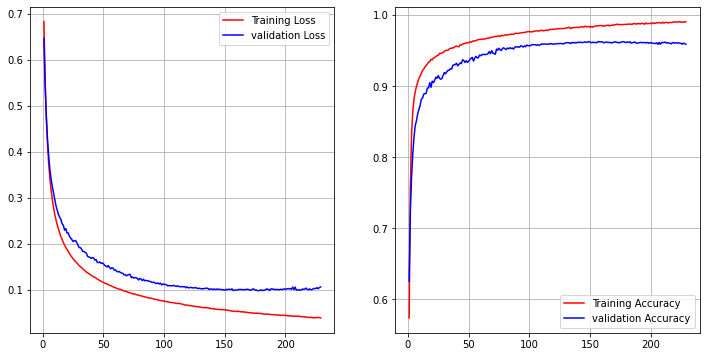

In [ ]:
main()

# Testing (with different Images)